In this project the goal is to predict if a credit applicant will default or not. This is a binary classification problem that involves considering various aspects common in any data science scenario such as data cleaning, data visualization, feature engineering, choosing and interpreting appropriate evaluation metrics, handling class imbalance, etc. The data used for this project is available at and consists of more than 100 columns with information about each credit application.   

In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# entrypoint of pyspark
from pyspark.sql import SparkSession

# import useful functions
import pyspark.sql.functions as F

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
spark = SparkSession.builder.appName('FraudDetection').getOrCreate()

23/07/24 18:59:34 WARN Utils: Your hostname, betor94-Satellite-L845D resolves to a loopback address: 127.0.1.1; using 192.168.0.6 instead (on interface wlp2s0)
23/07/24 18:59:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/24 18:59:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark 

In [5]:
current_application = spark.read.csv('files/application_data.csv', header=True, inferSchema=True)
#previous_application = spark.read.csv('files/previous_application.csv', header=True, inferSchema=True)

## Data information

Let's explore the columns in each dataframe

In [6]:
current_application.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_AG

In [6]:
previous_application.printSchema()

NameError: name 'previous_application' is not defined

In [8]:
current_application.select(['APARTMENTS_AVG']).show(4)

+--------------+
|APARTMENTS_AVG|
+--------------+
|        0.0247|
|        0.0959|
|          null|
|          null|
+--------------+
only showing top 4 rows



### Information functions

The first step requires understanding data which involves discovering the meaning of each column, identifying null values, discovering initial insights through summary statistics and data visualizations. 

In [5]:
from collections import Counter

# let's define a function to print general information about each dataframe
def count_dtypes(dataframe):
    counter = Counter([dtype[1] for dtype in dataframe.dtypes])
    return counter

def dataframe_info(dataframe):
    print("Columns datatypes counts")
    for dtype, count in count_dtypes(dataframe).items():
        print(dtype, ": ",count)

    print("Number of columns: ", len(dataframe.columns))
    print("Number of rows: ", dataframe.count())
    print("\n")

In [8]:
dataframe_info(current_application)
#info(previous_application)

Columns datatypes counts
int :  41
string :  16
double :  65
Number of columns:  122


Number of rows:  307511




We must also explore the number of null or nan values for each column. This way we can decide how to deal with missing values either by dropping a column or imputing values.

In [6]:
# Let's define a function to calculate the fraction of null or nan values in each column 
def null_fraction(dataframe):
    total_rows = dataframe.count()
    nulls = dataframe.select([(F.count(F.when(F.isnan(c) | F.isnull(c), c))/total_rows)\
                              .alias(c) for c in dataframe.columns])
    nulls = nulls.toPandas().T
    nulls = nulls.reset_index(drop=False)
    nulls.columns = ['column', 'fraction_of_missing']
    return nulls

def columns_dtypes(dataframe):
    df = pd.DataFrame(dataframe.dtypes)
    df.columns = ['column', 'dtype']
    return df

def columns_info(dataframe):
    nulls = null_fraction(dataframe)
    df = columns_dtypes(dataframe)
    return df.merge(nulls, on='column')

In [7]:
columns = columns_info(current_application)

NameError: name 'current_application' is not defined

In [11]:
columns.sort_values(by='fraction_of_missing', ascending=False)

column   dtype  fraction_of_missing
76                COMMONAREA_MEDI  double             0.698723
48                 COMMONAREA_AVG  double             0.698723
62                COMMONAREA_MODE  double             0.698723
70       NONLIVINGAPARTMENTS_MODE  double             0.694330
56        NONLIVINGAPARTMENTS_AVG  double             0.694330
84       NONLIVINGAPARTMENTS_MEDI  double             0.694330
86             FONDKAPREMONT_MODE  string             0.683862
68          LIVINGAPARTMENTS_MODE  double             0.683550
54           LIVINGAPARTMENTS_AVG  double             0.683550
82          LIVINGAPARTMENTS_MEDI  double             0.683550
52                  FLOORSMIN_AVG  double             0.678486
66                 FLOORSMIN_MODE  double             0.678486
80                 FLOORSMIN_MEDI  double             0.678486
75               YEARS_BUILD_MEDI  double             0.664978
61               YEARS_BUILD_MODE  double             0.664978
47                YEARS_BUILD_AVG  double             0.664978
21                    OWN_CAR_AGE  double             0.659908
81                  LANDAREA_MEDI  double             0.593767
67                  LANDAREA_MODE  double             0.593767
53                   LANDAREA_AVG  double             0.593767
73              BASEMENTAREA_MEDI  double             0.585160
45               BASEMENTAREA_AVG  double             0.585160
59              BASEMENTAREA_MODE  double             0.585160
41                   EXT_SOURCE_1  double             0.563811
71             NONLIVINGAREA_MODE  double             0.551792
57              NONLIVINGAREA_AVG  double             0.551792
85             NONLIVINGAREA_MEDI  double             0.551792
77                 ELEVATORS_MEDI  double             0.532960
49                  ELEVATORS_AVG  double             0.532960
63                 ELEVATORS_MODE  double             0.532960
89             WALLSMATERIAL_MODE  string             0.508408
72                APARTMENTS_MEDI  double             0.507497
44                 APARTMENTS_AVG  double             0.507497
58                APARTMENTS_MODE  double             0.507497
78                 ENTRANCES_MEDI  double             0.503488
50                  ENTRANCES_AVG  double             0.503488
64                 ENTRANCES_MODE  double             0.503488
55                 LIVINGAREA_AVG  double             0.501933
69                LIVINGAREA_MODE  double             0.501933
83                LIVINGAREA_MEDI  double             0.501933
87                 HOUSETYPE_MODE  string             0.501761
65                 FLOORSMAX_MODE  double             0.497608
79                 FLOORSMAX_MEDI  double             0.497608
51                  FLOORSMAX_AVG  double             0.497608
60   YEARS_BEGINEXPLUATATION_MODE  double             0.487810
74   YEARS_BEGINEXPLUATATION_MEDI  double             0.487810
46    YEARS_BEGINEXPLUATATION_AVG  double             0.487810
88                 TOTALAREA_MODE  double             0.482685
90            EMERGENCYSTATE_MODE  string             0.473983
28                OCCUPATION_TYPE  string             0.313455
43                   EXT_SOURCE_3  double             0.198253
116    AMT_REQ_CREDIT_BUREAU_HOUR  double             0.135016
117     AMT_REQ_CREDIT_BUREAU_DAY  double             0.135016
118    AMT_REQ_CREDIT_BUREAU_WEEK  double             0.135016
119     AMT_REQ_CREDIT_BUREAU_MON  double             0.135016
120     AMT_REQ_CREDIT_BUREAU_QRT  double             0.135016
121    AMT_REQ_CREDIT_BUREAU_YEAR  double             0.135016
11                NAME_TYPE_SUITE  string             0.004201
91       OBS_30_CNT_SOCIAL_CIRCLE  double             0.003320
92       DEF_30_CNT_SOCIAL_CIRCLE  double             0.003320
93       OBS_60_CNT_SOCIAL_CIRCLE  double             0.003320
94       DEF_60_CNT_SOCIAL_CIRCLE  double             0.003320
42                   EXT_SOURCE_2  double             0.00

In [12]:
message = "Number of columns with missing values: {}".format((columns['fraction_of_missing'] > 0).sum())
print(message)

Number of columns with missing values: 67


In [13]:
current_application.groupBy('TARGET').agg({'TARGET':'count'}).show()

+------+-------------+
|TARGET|count(TARGET)|
+------+-------------+
|     1|        24825|
|     0|       282686|
+------+-------------+



In [14]:
# Class imbalance
24825/282686

0.08781828601345662

Two flag variables (FLAG_OWN_REALTY and FLAG_OWN_CAR) are encoded as strings so we need to convert them into integer or boolean values. This reduces the number of categorical variables by 2 for a total of 14. Also let's convert the column CODE_GENDER into a numerical column.

In [15]:
def convert_flag(dataframe, columns, old, new):
    temp = dataframe.select('*')
    for col in columns:
        temp = temp.withColumn(col, F.when(dataframe[col]==old[0], new[0])\
                                    .when(dataframe[col]==old[1], new[1]))
    return temp

In [16]:
cols_to_convert = ['FLAG_OWN_REALTY', 'FLAG_OWN_CAR']
old = ['Y', 'N'] # old values
new = [1, 0] # values to replace with
current_application = convert_flag(current_application, cols_to_convert, old, new)

In [17]:
cols_to_convert = ['CODE_GENDER']
old = ['F', 'M'] # old values
new = [1, 0] # values to replace with
current_application = convert_flag(current_application, cols_to_convert, old, new)

In [18]:
current_application.select(['CODE_GENDER']).show()

+-----------+
|CODE_GENDER|
+-----------+
|          0|
|          1|
|          0|
|          1|
|          0|
|          0|
|          1|
|          0|
|          1|
|          0|
|          1|
|          1|
|          1|
|          0|
|          1|
|          0|
|          0|
|          1|
|          1|
|          1|
+-----------+
only showing top 20 rows



### Data splitting

Note that there are many columns with missing values. For the "current_application" dataframe many columns with double datatypes present a fraction of **missing values** larger than 0.45; however, we cannot just drop these columns since they could provide insights to predict credit default in cases when this information is available. Therefore, it is important to analyze the relationship between these columns and the target before making any decision. Before we can perform any kind of analysis we must split the data into a training and test datasets to avoid **data leakage**.

In [19]:
# Since there is no temporal information we can split the data randomly
train = current_application.sample(False, fraction=0.8, seed=42)
test = current_application.join(train, on='SK_ID_CURR', how='leftanti')

In [20]:
train.count() + test.count()

307511

Let's create a sample to perform a statistical and graphical analysis. Also let's load the dataset with columns description.

In [21]:
descriptions = spark.read.csv('files/columns_description.csv', header=True, inferSchema=True)

In [22]:
descriptions.show()

+---+----------------+--------------------+--------------------+--------------------+
|_c0|           Table|                 Row|         Description|             Special|
+---+----------------+--------------------+--------------------+--------------------+
|  1|application_data|          SK_ID_CURR|ID of loan in our...|                null|
|  2|application_data|              TARGET|Target variable (...|                null|
|  5|application_data|  NAME_CONTRACT_TYPE|Identification if...|                null|
|  6|application_data|         CODE_GENDER|Gender of the client|                null|
|  7|application_data|        FLAG_OWN_CAR|Flag if the clien...|                null|
|  8|application_data|     FLAG_OWN_REALTY|Flag if client ow...|                null|
|  9|application_data|        CNT_CHILDREN|Number of childre...|                null|
| 10|application_data|    AMT_INCOME_TOTAL|Income of the client|                null|
| 11|application_data|          AMT_CREDIT|Credit amou

23/07/17 16:59:43 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Table, Row, Description, Special
 Schema: _c0, Table, Row, Description, Special
Expected: _c0 but found: 
CSV file: file:///home/betor94/Documents/Projects/FraudDetection/files/columns_description.csv


## Exploratory Data Analysis

Once we have divided the data we can start exploring variables to find columns with missing values, erroneous data and relevant features.To do this I will create a small random sample to create data visualizations since using all data might be computationally expensive.

In [23]:
# Create a sample from the training set
sample = train.sample(withReplacement=False, fraction=0.05, seed=42)

In [24]:
columns_missing = columns_info(sample)

In [25]:
columns_missing.sort_values(by='fraction_of_missing', ascending=False)

column   dtype  fraction_of_missing
62                COMMONAREA_MODE  double             0.706333
48                 COMMONAREA_AVG  double             0.706333
76                COMMONAREA_MEDI  double             0.706333
70       NONLIVINGAPARTMENTS_MODE  double             0.703754
56        NONLIVINGAPARTMENTS_AVG  double             0.703754
84       NONLIVINGAPARTMENTS_MEDI  double             0.703754
86             FONDKAPREMONT_MODE  string             0.692797
82          LIVINGAPARTMENTS_MEDI  double             0.692475
54           LIVINGAPARTMENTS_AVG  double             0.692475
68          LIVINGAPARTMENTS_MODE  double             0.692475
66                 FLOORSMIN_MODE  double             0.686916
52                  FLOORSMIN_AVG  double             0.686916
80                 FLOORSMIN_MEDI  double             0.686916
75               YEARS_BUILD_MEDI  double             0.672092
61               YEARS_BUILD_MODE  double             0.672092
47                YEARS_BUILD_AVG  double             0.672092
21                    OWN_CAR_AGE  double             0.654689
81                  LANDAREA_MEDI  double             0.598131
67                  LANDAREA_MODE  double             0.598131
53                   LANDAREA_AVG  double             0.598131
59              BASEMENTAREA_MODE  double             0.590155
73              BASEMENTAREA_MEDI  double             0.590155
45               BASEMENTAREA_AVG  double             0.590155
41                   EXT_SOURCE_1  double             0.561473
57              NONLIVINGAREA_AVG  double             0.557606
85             NONLIVINGAREA_MEDI  double             0.557606
71             NONLIVINGAREA_MODE  double             0.557606
77                 ELEVATORS_MEDI  double             0.537705
63                 ELEVATORS_MODE  double             0.537705
49                  ELEVATORS_AVG  double             0.537705
89             WALLSMATERIAL_MODE  string             0.513777
58                APARTMENTS_MODE  double             0.513213
72                APARTMENTS_MEDI  double             0.513213
44                 APARTMENTS_AVG  double             0.513213
50                  ENTRANCES_AVG  double             0.509185
64                 ENTRANCES_MODE  double             0.509185
78                 ENTRANCES_MEDI  double             0.509185
87                 HOUSETYPE_MODE  string             0.507734
55                 LIVINGAREA_AVG  double             0.505881
69                LIVINGAREA_MODE  double             0.505881
83                LIVINGAREA_MEDI  double             0.505881
65                 FLOORSMAX_MODE  double             0.503062
51                  FLOORSMAX_AVG  double             0.503062
79                 FLOORSMAX_MEDI  double             0.503062
60   YEARS_BEGINEXPLUATATION_MODE  double             0.493071
74   YEARS_BEGINEXPLUATATION_MEDI  double             0.493071
46    YEARS_BEGINEXPLUATATION_AVG  double             0.493071
88                 TOTALAREA_MODE  double             0.488318
90            EMERGENCYSTATE_MODE  string             0.481711
28                OCCUPATION_TYPE  string             0.315018
43                   EXT_SOURCE_3  double             0.200048
116    AMT_REQ_CREDIT_BUREAU_HOUR  double             0.132936
117     AMT_REQ_CREDIT_BUREAU_DAY  double             0.132936
118    AMT_REQ_CREDIT_BUREAU_WEEK  double             0.132936
119     AMT_REQ_CREDIT_BUREAU_MON  double             0.132936
120     AMT_REQ_CREDIT_BUREAU_QRT  double             0.132936
121    AMT_REQ_CREDIT_BUREAU_YEAR  double             0.132936
11                NAME_TYPE_SUITE  string             0.004109
92       DEF_30_CNT_SOCIAL_CIRCLE  double             0.002498
91       OBS_30_CNT_SOCIAL_CIRCLE  double             0.002498
93       OBS_60_CNT_SOCIAL_CIRCLE  double             0.002498
94       DEF_60_CNT_SOCIAL_CIRCLE  double             0.002498
42                   EXT_SOURCE_2  double             0.00

In [26]:
message = "Number of columns with missing values: {}".format((columns_missing['fraction_of_missing'] > 0).sum())
print(message)

Number of columns with missing values: 65


In [27]:
# Convert to pandas dataframe to create visualizations
sample = sample.toPandas()

In [28]:
target_count = sample['TARGET'].value_counts()
target_count

0    11455
1      957
Name: TARGET, dtype: int64

In [29]:
# class imbalance is preserved in the sample 
957/11455

0.08354430379746836

### Correlation matrix

To begin with the analysis let's compute the correlation between all numeric variables. This will provide some information about associated variables and redundancies.

In [30]:
sample_correlations = sample.corr()

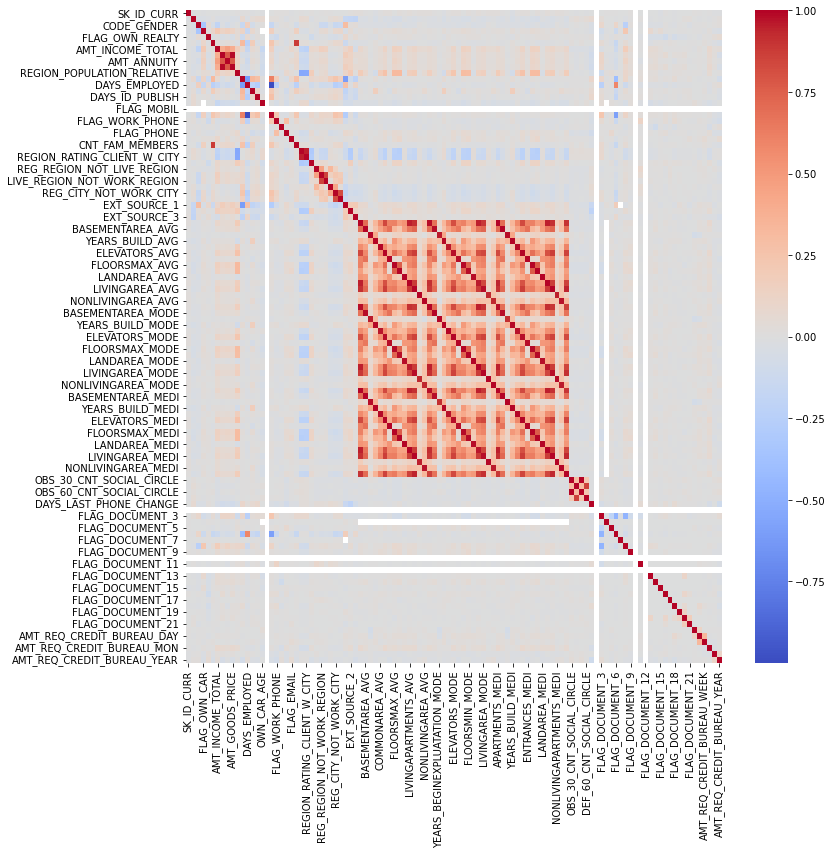

In [31]:
fig, ax = plt.subplots(1,1, figsize=(12, 12))

sns.heatmap(sample_correlations, cmap='coolwarm', ax=ax)

plt.show()

We can observe a region of large correlations that correspond to variables with "building" information.

Note that many columns with a high fraction of missing values contain information about the building where the client lives. Let's investigate if these columns are related to the target variable (default or not). It might be possible that people who is likely to default is also reluctant to provide information of this kind. Another explanation is that this information is not available to the client.

In [32]:
# filter columns with information about the building where the client lives 
building_information = descriptions.where(descriptions.Description.like('Normalized information%')).\
                   select(['Row', 'Description']).toPandas()

In [33]:
building_information

Row  \
0                 APARTMENTS_AVG   
1               BASEMENTAREA_AVG   
2    YEARS_BEGINEXPLUATATION_AVG   
3                YEARS_BUILD_AVG   
4                 COMMONAREA_AVG   
5                  ELEVATORS_AVG   
6                  ENTRANCES_AVG   
7                  FLOORSMAX_AVG   
8                  FLOORSMIN_AVG   
9                   LANDAREA_AVG   
10          LIVINGAPARTMENTS_AVG   
11                LIVINGAREA_AVG   
12       NONLIVINGAPARTMENTS_AVG   
13             NONLIVINGAREA_AVG   
14               APARTMENTS_MODE   
15             BASEMENTAREA_MODE   
16  YEARS_BEGINEXPLUATATION_MODE   
17              YEARS_BUILD_MODE   
18               COMMONAREA_MODE   
19                ELEVATORS_MODE   
20                ENTRANCES_MODE   
21                FLOORSMAX_MODE   
22                FLOORSMIN_MODE   
23                 LANDAREA_MODE   
24         LIVINGAPARTMENTS_MODE   
25               LIVINGAREA_MODE   
26      NONLIVINGAPARTMENTS_MODE   
27            NONLIVINGAREA_MODE   
28               APARTMENTS_MEDI   
29             BASEMENTAREA_MEDI   
30  YEARS_BEGINEXPLUATATION_MEDI   
31              YEARS_BUILD_MEDI   
32               COMMONAREA_MEDI   
33                ELEVATORS_MEDI   
34                ENTRANCES_MEDI   
35                FLOORSMAX_MEDI   
36                FLOORSMIN_MEDI   
37                 LANDAREA_MEDI   
38         LIVINGAPARTMENTS_MEDI   
39               LIVINGAREA_MEDI   
40      NONLIVINGAPARTMENTS_MEDI   
41            NONLIVINGAREA_MEDI   
42            FONDKAPREMONT_MODE   
43                HOUSETYPE_MODE   
44                TOTALAREA_MODE   
45            WALLSMATERIAL_MODE   
46           EMERGENCYSTATE_MODE   

                                          Description  
0   Normalized information about building where th...  
1   Normalized information about building where th...  
2   Normalized information about building where th...  
3   Normalized information about building where th...  
4   Normalized information about building where th...  
5   Normalized information about building where th...  
6   Normalized information about building where th...  
7   Normalized information about building where th...  
8   Normalized information about building where th...  
9   Normalized information about building where th...  
10  Normalized information about building where th...  
11  Normalized information about building where th...  
12  Normalized information about building where th...  
13  Normalized information about building where th...  
14  Normalized information about building where th...  
15  Normalized information about building where th...  
16  Normalized information about building where th...  
17  Normalized information about building where th...  
18  Normalized information about building where th...  
19  Normalized information about building where th...  
20  Normalized information about building where th...  
21  Normalized information about building where th...  
22  Normalized information about building where th...  
23  Normalized information about building where th...  
24  Normalized information about building where th...  
25  Normalized information about building where th...  
26  Normalized information about building where th...  
27  Normalized information about building where th...  
28  Normalized information about building where th...  
29  Normalized information about building where th...  
30  Normalized information about building where th...  
31  Normalized information about building where th...  
32  Normalized information about building where th...  
33  Normalized information about building where th...  
34  Normalized information about building where th...  
35  Normalized information about building where th...  
36  Normalized information about building where th...  
37  Normalized information about building where th...  
38  Normalized information about building where th...  
39  Normalized information about building where th...  
40  

In [87]:
columns[columns['column'].isin(building_information['Row'])].sort_values(by='fraction_of_missing', ascending=False)

column   dtype  fraction_of_missing
76               COMMONAREA_MEDI  double             0.698723
48                COMMONAREA_AVG  double             0.698723
62               COMMONAREA_MODE  double             0.698723
70      NONLIVINGAPARTMENTS_MODE  double             0.694330
84      NONLIVINGAPARTMENTS_MEDI  double             0.694330
56       NONLIVINGAPARTMENTS_AVG  double             0.694330
86            FONDKAPREMONT_MODE  string             0.683862
82         LIVINGAPARTMENTS_MEDI  double             0.683550
68         LIVINGAPARTMENTS_MODE  double             0.683550
54          LIVINGAPARTMENTS_AVG  double             0.683550
66                FLOORSMIN_MODE  double             0.678486
52                 FLOORSMIN_AVG  double             0.678486
80                FLOORSMIN_MEDI  double             0.678486
61              YEARS_BUILD_MODE  double             0.664978
75              YEARS_BUILD_MEDI  double             0.664978
47               YEARS_BUILD_AVG  double             0.664978
81                 LANDAREA_MEDI  double             0.593767
53                  LANDAREA_AVG  double             0.593767
67                 LANDAREA_MODE  double             0.593767
59             BASEMENTAREA_MODE  double             0.585160
73             BASEMENTAREA_MEDI  double             0.585160
45              BASEMENTAREA_AVG  double             0.585160
57             NONLIVINGAREA_AVG  double             0.551792
85            NONLIVINGAREA_MEDI  double             0.551792
71            NONLIVINGAREA_MODE  double             0.551792
63                ELEVATORS_MODE  double             0.532960
77                ELEVATORS_MEDI  double             0.532960
49                 ELEVATORS_AVG  double             0.532960
89            WALLSMATERIAL_MODE  string             0.508408
44                APARTMENTS_AVG  double             0.507497
58               APARTMENTS_MODE  double             0.507497
72               APARTMENTS_MEDI  double             0.507497
78                ENTRANCES_MEDI  double             0.503488
64                ENTRANCES_MODE  double             0.503488
50                 ENTRANCES_AVG  double             0.503488
69               LIVINGAREA_MODE  double             0.501933
83               LIVINGAREA_MEDI  double             0.501933
55                LIVINGAREA_AVG  double             0.501933
87                HOUSETYPE_MODE  string             0.501761
65                FLOORSMAX_MODE  double             0.497608
79                FLOORSMAX_MEDI  double             0.497608
51                 FLOORSMAX_AVG  double             0.497608
46   YEARS_BEGINEXPLUATATION_AVG  double             0.487810
74  YEARS_BEGINEXPLUATATION_MEDI  double             0.487810
60  YEARS_BEGINEXPLUATATION_MODE  double             0.487810
88                TOTALAREA_MODE  double             0.482685
90           EMERGENCYSTATE_MODE  string             0.473983

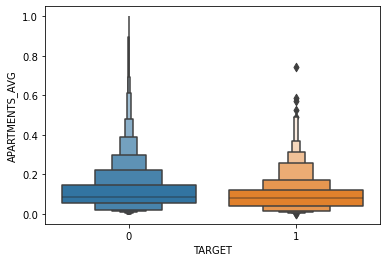

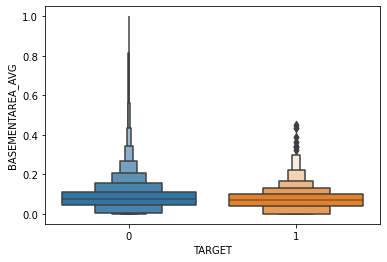

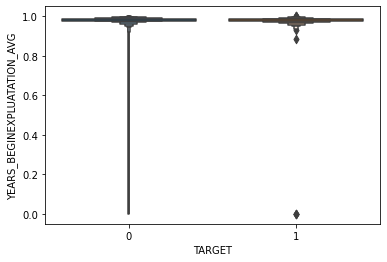

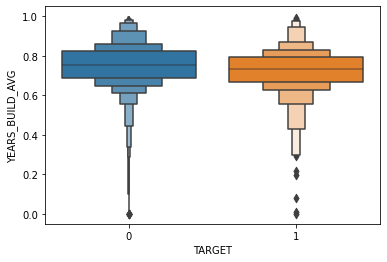

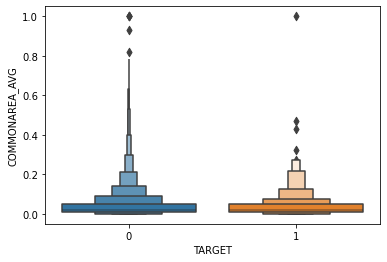

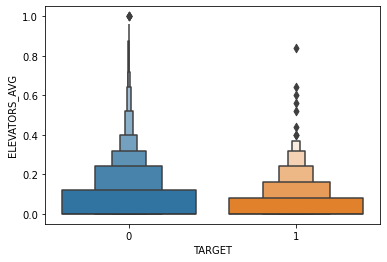

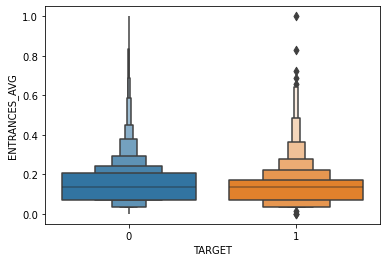

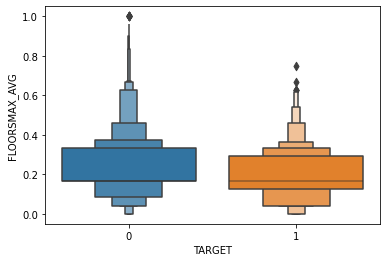

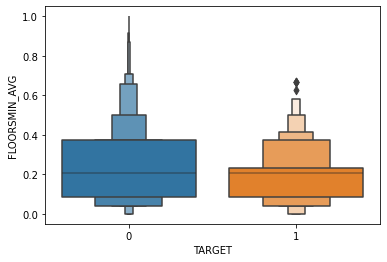

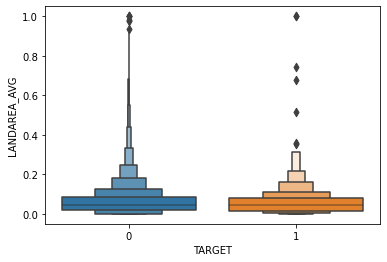

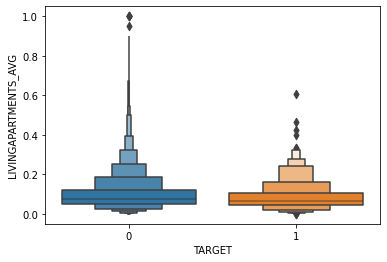

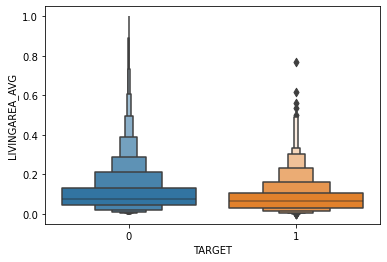

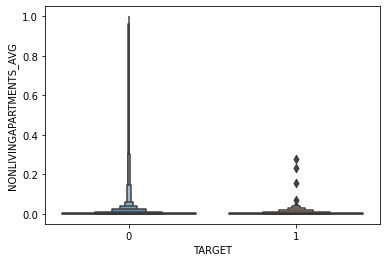

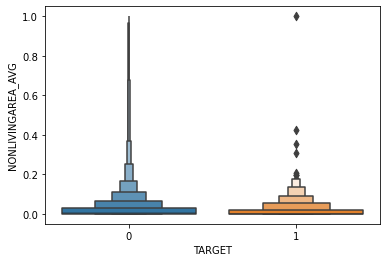

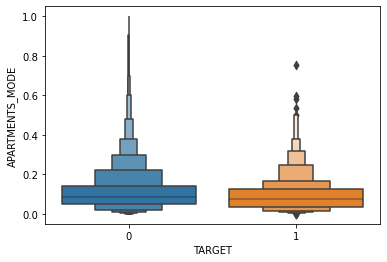

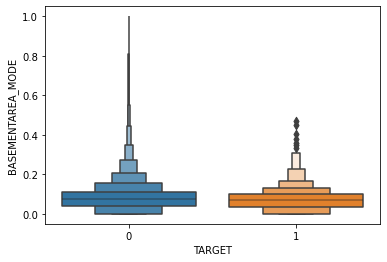

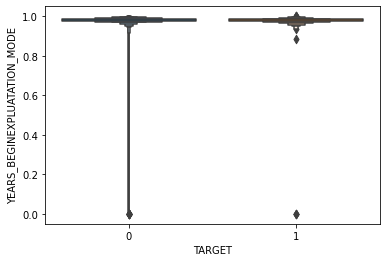

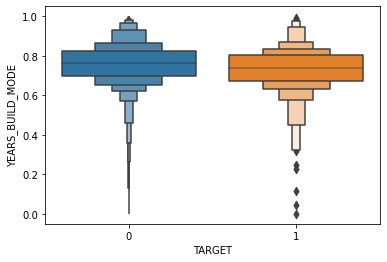

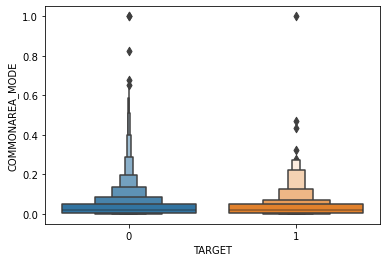

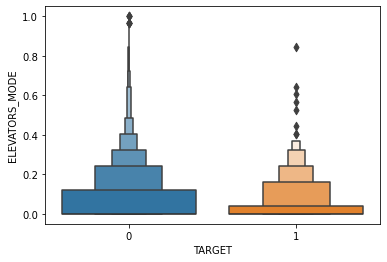

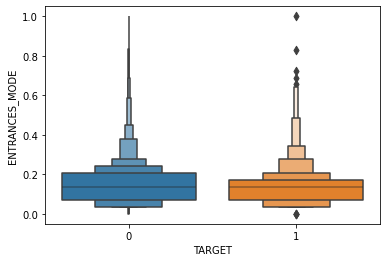

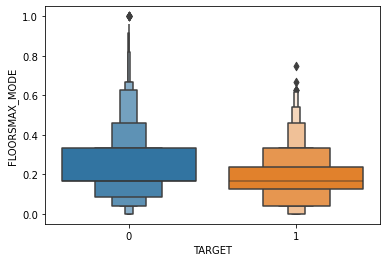

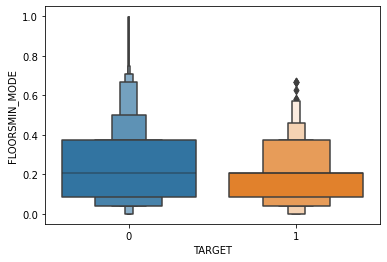

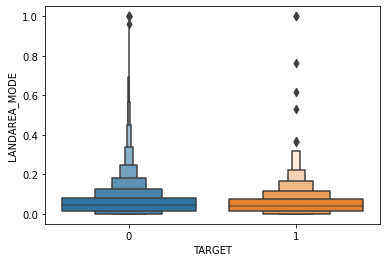

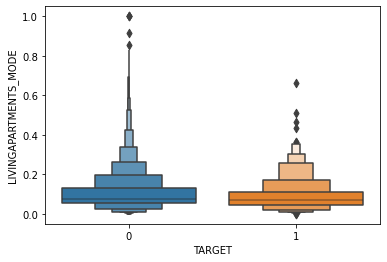

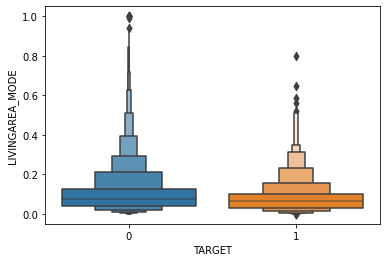

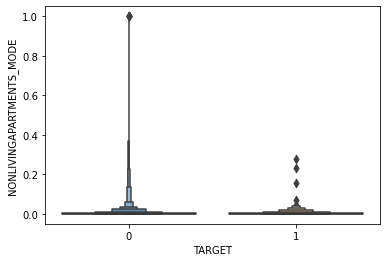

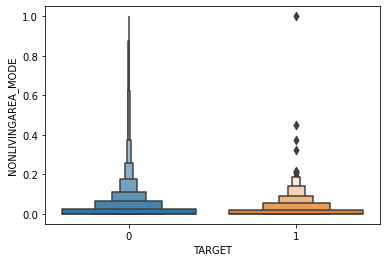

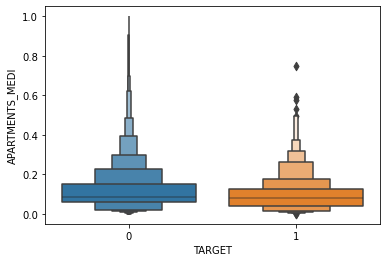

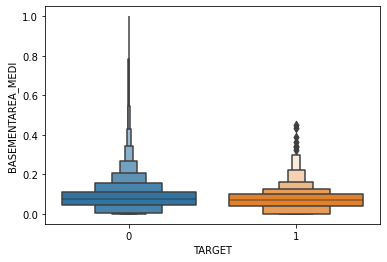

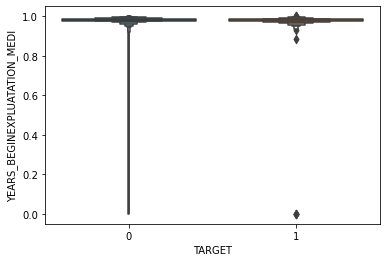

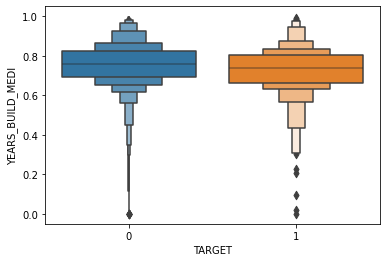

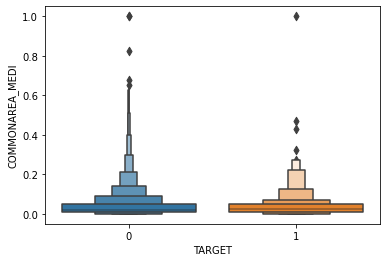

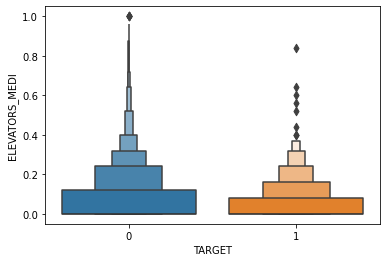

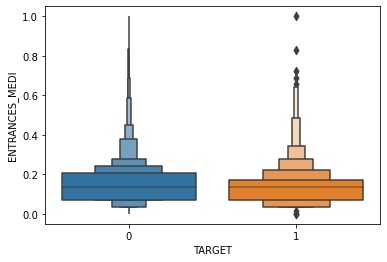

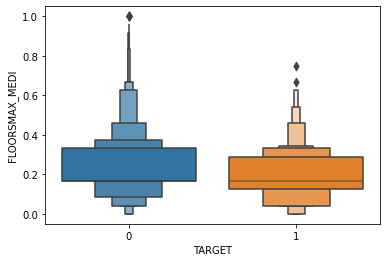

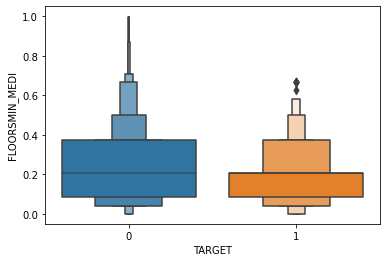

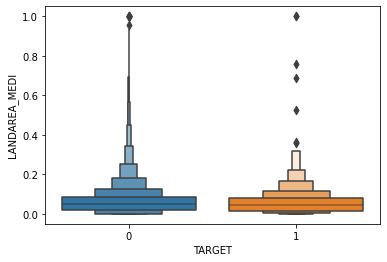

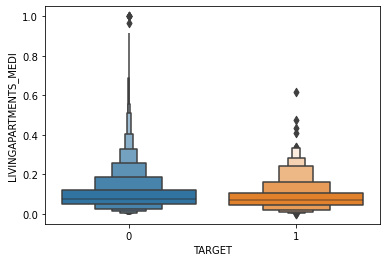

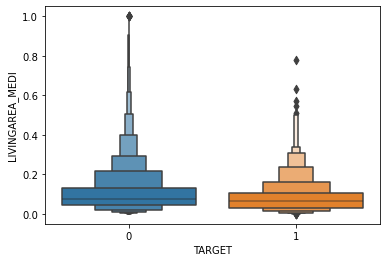

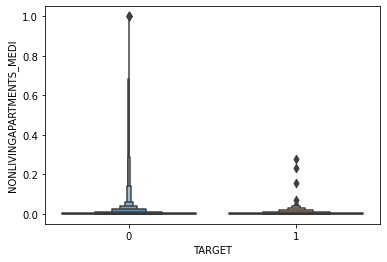

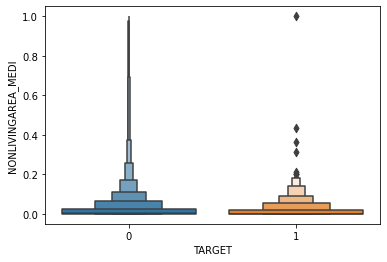

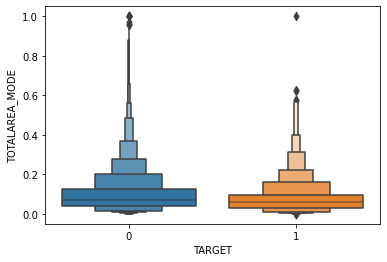

In [95]:
# Let's explore numerical columns
for col in building_information['Row'].values[0:]:
    if not columns[columns['column']==col]['dtype'].values[0] == 'string':
        sns.boxenplot(x=sample['TARGET'], y=sample[col])
        plt.show()

TARGET                        0         1
FONDKAPREMONT_MODE                       
not specified          0.929461  0.070539
org spec account       0.957346  0.042654
reg oper account       0.931478  0.068522
reg oper spec account  0.950617  0.049383
All                    0.935222  0.064778


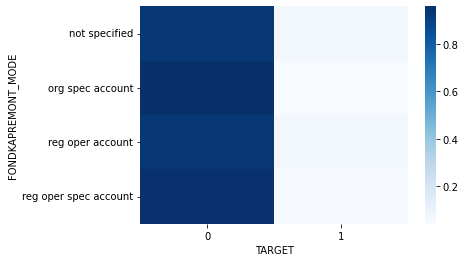

TARGET                   0         1
HOUSETYPE_MODE                      
block of flats    0.938124  0.061876
specific housing  0.877193  0.122807
terraced house    0.951220  0.048780
All               0.937643  0.062357


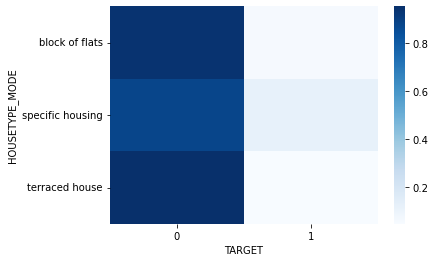

TARGET                     0         1
WALLSMATERIAL_MODE                    
Block               0.934286  0.065714
Mixed               0.989011  0.010989
Monolithic          0.983051  0.016949
Others              0.962264  0.037736
Panel               0.939741  0.060259
Stone, brick        0.936484  0.063516
Wooden              0.897674  0.102326
All                 0.937862  0.062138


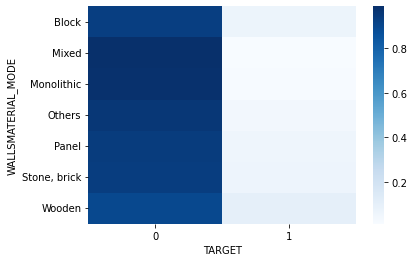

TARGET                      0         1
EMERGENCYSTATE_MODE                    
No                   0.937460  0.062540
Yes                  0.931624  0.068376
All                  0.937354  0.062646


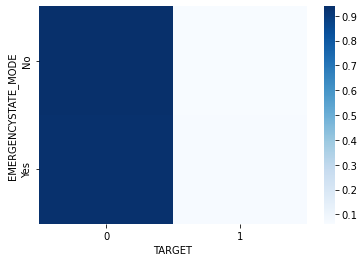

In [30]:
# Now categorical columns
for col in building_information['Row'].values[0:]:
    if columns[columns['column']==col]['dtype'].values[0] == 'string':
        cross = pd.crosstab(sample[col], sample['TARGET'], margins=True, normalize='index')
        print(cross)
        cross = pd.crosstab(sample[col], sample['TARGET'], normalize='index')
        sns.heatmap(cross, cmap="Blues")
        plt.show()

Looking at the previous graphs we can observe that "building" columns are not very relevant in trying to predict credit default; some of them show some differences between default or not default, but all columns have a fraction of missing values larger than 0.48 and the reasons for this are not clear. It is plausible, however, that clients that are likely to default provide less information than those that donÂ´t. Let's explore this further.

In [34]:
# Find null values for building columns
building_nulls = sample[building_information['Row'].tolist()].isnull()

<AxesSubplot:ylabel='Density'>

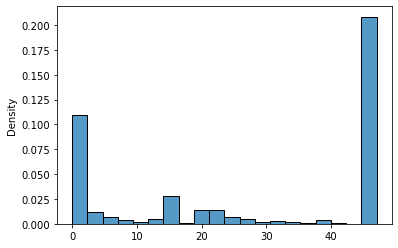

In [35]:
#Sum the number of null values for each row (loan application)
nulls_per_row = building_nulls.sum(axis=1)
sns.histplot(nulls_per_row, bins=20, stat='density')

We can notice that a large number of clients provided no building information. It is reasonable to think that a person could not have access to **all** this information but also it is very unlikely that he/she is completely uninformed. Following this reasoning, we can create a new binary variable that based on the histogram provides information about whether a person is hiding information or not. This allows to capture part of the information encoded in the "building columns" without having to retain all of them. 

In [36]:
# Select an intermediate threshold of 30
provides_info = (~(nulls_per_row > 30)).astype(int)

In [37]:
pd.crosstab(provides_info, sample['TARGET'], normalize='index')

TARGET         0         1
row_0                     
0       0.908434  0.091566
1       0.938131  0.061869

In [38]:
from scipy.stats import chi2_contingency
frequency_table = pd.crosstab(provides_info, sample['TARGET'])
chi2, pval, dof, expected = chi2_contingency(frequency_table)

In [39]:
# By applying a Chi-square test of independence of variables we observe that 
# there seems to be a relationship between the new variable and the target.
chi2, pval

(38.014523597199975, 7.021996859035433e-10)

We need to create this variable in the train and test dataframes and drop the "building" columns. 

In [40]:
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window

In [41]:
def binary_column(dataframe, columns, index_col, name, thresh=30):
    #Create a copy of columns and add index_column
    cols = columns.copy()
    cols.insert(0, index_col)
    
    isnull = dataframe.select(cols)
    
    # replace dataframe values with 0 if values are null, 1 otherwise 
    for col in cols[1:]:
        isnull = isnull.withColumn(col, isnull[col].isNull()\
                                   .cast(IntegerType()))
    # Convert dataframe of columns into a dataframe of single array column
    isnull = isnull.withColumn('_cols_array', F.array(*isnull.columns[1:]))
    # Sum elements in array columns to count number of missing values
    isnull = isnull.withColumn('_sum', F.aggregate('_cols_array', F.lit(0), lambda acc, x: acc + x))
    # Create and select binary column
    isnull = isnull.withColumn(name, F.when(isnull['_sum']>thresh, 1).otherwise(0)).select([index_col, name])
    
    return dataframe.join(isnull, on=index_col)

In [42]:
building_cols= building_information['Row'].tolist()

train = binary_column(train, building_cols, 'SK_ID_CURR', 'provides_building_info')
test = binary_column(test, building_cols, 'SK_ID_CURR', 'provides_building_info')

train = train.drop(*building_cols)
test = test.drop(*building_cols)

In [43]:
dataframe_info(train)

Columns datatypes counts
int :  45
string :  9
double :  22
Number of columns:  76


Number of rows:  245914




In [44]:
dataframe_info(test)

Columns datatypes counts
int :  45
string :  9
double :  22
Number of columns:  76


Number of rows:  61597




Now we can continue analyzing the remaining columns.

In [45]:
# Remove building columns from dataframe
columns_missing = columns_missing[~(columns_missing['column'].isin(building_cols))]

In [46]:
columns_missing.sort_values('fraction_of_missing', ascending=False)

column   dtype  fraction_of_missing
21                   OWN_CAR_AGE  double             0.654689
41                  EXT_SOURCE_1  double             0.561473
28               OCCUPATION_TYPE  string             0.315018
43                  EXT_SOURCE_3  double             0.200048
116   AMT_REQ_CREDIT_BUREAU_HOUR  double             0.132936
121   AMT_REQ_CREDIT_BUREAU_YEAR  double             0.132936
117    AMT_REQ_CREDIT_BUREAU_DAY  double             0.132936
119    AMT_REQ_CREDIT_BUREAU_MON  double             0.132936
118   AMT_REQ_CREDIT_BUREAU_WEEK  double             0.132936
120    AMT_REQ_CREDIT_BUREAU_QRT  double             0.132936
11               NAME_TYPE_SUITE  string             0.004109
92      DEF_30_CNT_SOCIAL_CIRCLE  double             0.002498
94      DEF_60_CNT_SOCIAL_CIRCLE  double             0.002498
93      OBS_60_CNT_SOCIAL_CIRCLE  double             0.002498
91      OBS_30_CNT_SOCIAL_CIRCLE  double             0.002498
42                  EXT_SOURCE_2  double             0.001853
10               AMT_GOODS_PRICE  double             0.001209
9                    AMT_ANNUITY  double             0.000081
101              FLAG_DOCUMENT_7     int             0.000000
95        DAYS_LAST_PHONE_CHANGE  double             0.000000
96               FLAG_DOCUMENT_2     int             0.000000
97               FLAG_DOCUMENT_3     int             0.000000
98               FLAG_DOCUMENT_4     int             0.000000
99               FLAG_DOCUMENT_5     int             0.000000
100              FLAG_DOCUMENT_6     int             0.000000
103              FLAG_DOCUMENT_9     int             0.000000
102              FLAG_DOCUMENT_8     int             0.000000
115             FLAG_DOCUMENT_21     int             0.000000
104             FLAG_DOCUMENT_10     int             0.000000
40             ORGANIZATION_TYPE  string             0.000000
106             FLAG_DOCUMENT_12     int             0.000000
107             FLAG_DOCUMENT_13     int             0.000000
108             FLAG_DOCUMENT_14     int             0.000000
109             FLAG_DOCUMENT_15     int             0.000000
110             FLAG_DOCUMENT_16     int             0.000000
111             FLAG_DOCUMENT_17     int             0.000000
112             FLAG_DOCUMENT_18     int             0.000000
113             FLAG_DOCUMENT_19     int             0.000000
114             FLAG_DOCUMENT_20     int             0.000000
105             FLAG_DOCUMENT_11     int             0.000000
0                     SK_ID_CURR     int             0.000000
39       LIVE_CITY_NOT_WORK_CITY     int             0.000000
12              NAME_INCOME_TYPE  string             0.000000
18                 DAYS_EMPLOYED     int             0.000000
17                    DAYS_BIRTH     int             0.000000
16    REGION_POPULATION_RELATIVE  double             0.000000
15             NAME_HOUSING_TYPE  string             0.000000
14            NAME_FAMILY_STATUS  string             0.000000
13           NAME_EDUCATION_TYPE  string             0.000000
8                     AMT_CREDIT  double             0.000000
38        REG_CITY_NOT_WORK_CITY     int             0.000000
7               AMT_INCOME_TOTAL  double             0.000000
6                   CNT_CHILDREN     int             0.000000
5                FLAG_OWN_REALTY     int             0.000000
4                   FLAG_OWN_CAR     int             0.000000
3                    CODE_GENDER     int             0.000000
2             NAME_CONTRACT_TYPE  string             0.000000
19             DAYS_REGISTRATION  double             0.000000
20               DAYS_ID_PUBLISH     int             0.000000
22                    FLAG_MOBIL     int             0.000000
23                FLAG_EMP_PHONE     int             0.000000
24               FLAG_WORK_PHONE     int             0.000000
25              FLAG_CONT_MOBILE     int             0.000000
26                    FLAG_PHONE     int             0.000

It seems that persons that default tend to have cars that are a little bit older (OWN_CAR_AGE). This column contains many missing values but this is explained by the fact that these correspond to people who do not own a car (FLAG_OWN_CAR). It is easy to see that this variable might be useful when applying tree-based models since a tree can first filter based on whether a person has a car or not. If we impute missing values with an arbitrary number then this variable becomes uninformative for people that do not own a car and is not used by the tree model. Note that this imputed column might affect other ml algorithms.

When applying ML learning algorithms it is useful to create a **flag (binary) indicator** for columns with imputed values. Let's create a flag column for each column that has imputed values.

In [47]:
def imputed_flag_column(dataframe, column):
    flag_column = 'is_imputed_' + column 
    temp = dataframe.select('*')
    temp = temp.withColumn(flag_column, F.when(F.isnan(temp[column]) | F.isnull(temp[column]), 1)\
                          .otherwise(0))
    return temp

In [107]:
temp = imputed_flag_column(train, 'OWN_CAR_AGE')

In [48]:
# Missing values in OWN_CAR_AGE correspond to 0 values in FLAG_OWN_CAR
sample['FLAG_OWN_CAR'].value_counts(), sample['OWN_CAR_AGE'].isna().value_counts()

(0    8126
 1    4286
 Name: FLAG_OWN_CAR, dtype: int64,
 True     8126
 False    4286
 Name: OWN_CAR_AGE, dtype: int64)

<AxesSubplot:xlabel='TARGET', ylabel='OWN_CAR_AGE'>

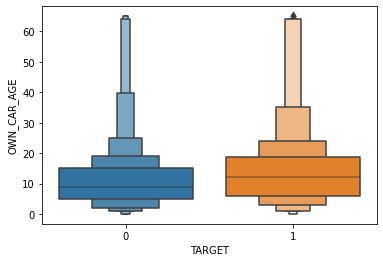

In [49]:
sns.boxenplot(y='OWN_CAR_AGE', x='TARGET', data=sample)

<AxesSubplot:xlabel='FLAG_OWN_CAR', ylabel='Percent'>

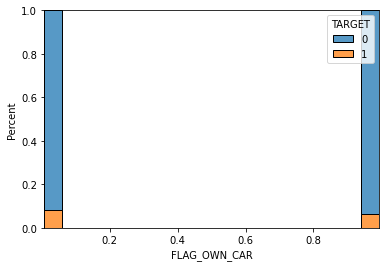

In [50]:
sns.histplot(data=sample, x="FLAG_OWN_CAR", stat='percent', hue="TARGET", multiple="fill", shrink=.8)

In [51]:
# A statistical test suggests a weak association between not owning a car and defaulting
frequency_table = pd.crosstab(sample['FLAG_OWN_CAR'], sample['TARGET'])
chi2, pval, dof, expected = chi2_contingency(frequency_table)
chi2, pval

(13.522945960270084, 0.00023566418411127488)

In [52]:
pd.crosstab(sample['FLAG_OWN_CAR'], sample['TARGET'], normalize='index')

TARGET               0         1
FLAG_OWN_CAR                    
0             0.916441  0.083559
1             0.935138  0.064862

Let's create a list of columns with imputed values and fill missing values in the 'OWN_CAR_AGE' column  with 0. We need to create a flag variable first to indicate this column has imputed values.

In [53]:
imputed_columns = []
imputed_columns.append('OWN_CAR_AGE')
imputed_columns

['OWN_CAR_AGE']

In [54]:
train = imputed_flag_column(train, 'OWN_CAR_AGE')
test = imputed_flag_column(test, 'OWN_CAR_AGE')

In [55]:
test.columns

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_

In [56]:
# modify train and test dataframe to fill missing value in 'OWN_CAR_AGE' column
train = train.fillna(0, subset=['OWN_CAR_AGE'])
test = test.fillna(0, subset=['OWN_CAR_AGE'])

In [57]:
columns_missing.sort_values(by='fraction_of_missing', ascending=False).head(20)

column   dtype  fraction_of_missing
21                  OWN_CAR_AGE  double             0.654689
41                 EXT_SOURCE_1  double             0.561473
28              OCCUPATION_TYPE  string             0.315018
43                 EXT_SOURCE_3  double             0.200048
116  AMT_REQ_CREDIT_BUREAU_HOUR  double             0.132936
121  AMT_REQ_CREDIT_BUREAU_YEAR  double             0.132936
117   AMT_REQ_CREDIT_BUREAU_DAY  double             0.132936
119   AMT_REQ_CREDIT_BUREAU_MON  double             0.132936
118  AMT_REQ_CREDIT_BUREAU_WEEK  double             0.132936
120   AMT_REQ_CREDIT_BUREAU_QRT  double             0.132936
11              NAME_TYPE_SUITE  string             0.004109
92     DEF_30_CNT_SOCIAL_CIRCLE  double             0.002498
94     DEF_60_CNT_SOCIAL_CIRCLE  double             0.002498
93     OBS_60_CNT_SOCIAL_CIRCLE  double             0.002498
91     OBS_30_CNT_SOCIAL_CIRCLE  double             0.002498
42                 EXT_SOURCE_2  double             0.001853
10              AMT_GOODS_PRICE  double             0.001209
9                   AMT_ANNUITY  double             0.000081
101             FLAG_DOCUMENT_7     int             0.000000
95       DAYS_LAST_PHONE_CHANGE  double             0.000000

Variables 'EXT_SOURCE_N' seem relevant. EXT_SOURCE_1 contains a large fraction of missing values. We can impute a 0 value meaning that the client has no corresponding score. We can also combine these three scores to create a new variable.

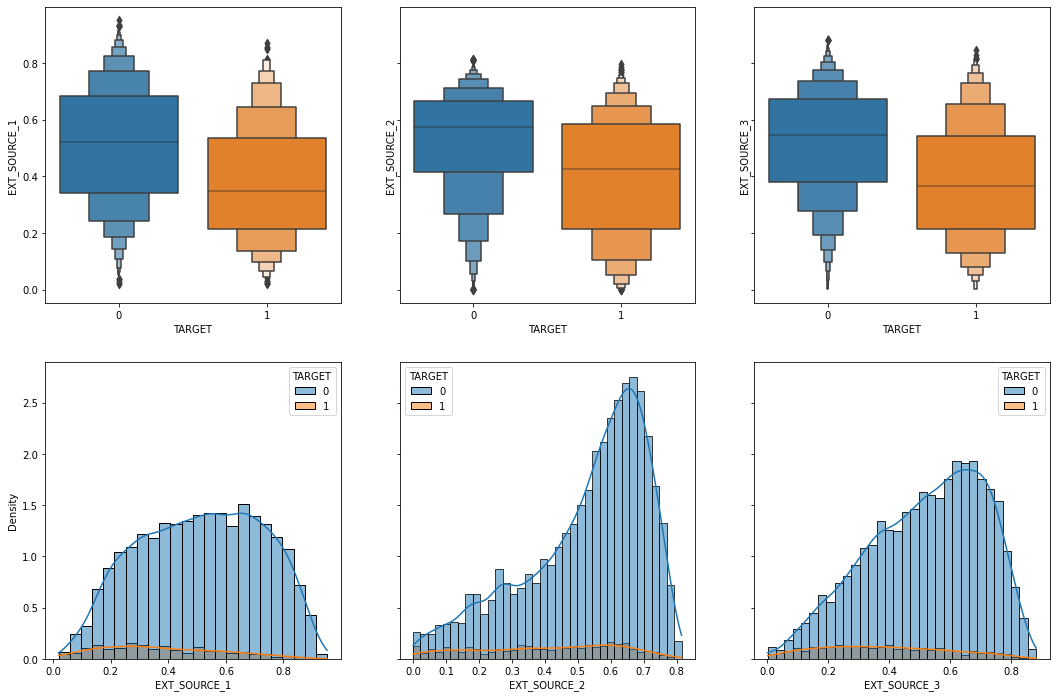

In [58]:
fig, ax = plt.subplots(2,3, figsize=(18,12), sharey='row')

ax= ax.flatten()

sns.boxenplot(data=sample, y='EXT_SOURCE_1', x='TARGET', ax=ax[0])
sns.boxenplot(data=sample, y='EXT_SOURCE_2', x='TARGET', ax=ax[1])
sns.boxenplot(data=sample, y='EXT_SOURCE_3', x='TARGET', ax=ax[2])

sns.histplot(data=sample, x='EXT_SOURCE_1', hue='TARGET', stat='density', kde=True, ax=ax[3])
sns.histplot(data=sample, x='EXT_SOURCE_2', hue='TARGET', stat='density', kde=True, ax=ax[4])
sns.histplot(data=sample, x='EXT_SOURCE_3', hue='TARGET', stat='density', kde=True, ax=ax[5])

plt.show()

In [59]:
# define a weight according to the number of non missing values of each column
w1 = (~sample['EXT_SOURCE_1'].isna()).mean()
w2 = (~sample['EXT_SOURCE_2'].isna()).mean()
w3 = (~sample['EXT_SOURCE_3'].isna()).mean()

w=w1+w2+w3
w1 = w1/w
w2 = w2/w
w3 = w3/w

In [60]:
EXTERNAL_SOURCE_ALL = (w1*sample['EXT_SOURCE_1'].fillna(0) \
                    + w2*sample['EXT_SOURCE_2'].fillna(0) + w3*sample['EXT_SOURCE_3'].fillna(0))

In [61]:
nums = np.array([10, 90, 40])
tot = np.sum(nums)
nums/tot

array([0.07142857, 0.64285714, 0.28571429])

This new variable reduces variance of the distributions

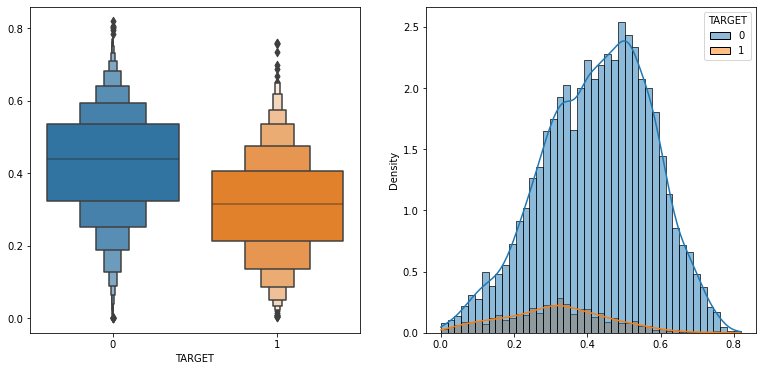

In [62]:
fig, ax = plt.subplots(1,2, figsize=(13,6))

sns.boxenplot(y=EXTERNAL_SOURCE_ALL, x=sample['TARGET'], ax=ax[0])
sns.histplot(x=EXTERNAL_SOURCE_ALL, hue=sample['TARGET'], stat='density', kde=True, ax=ax[1])

plt.show()

We have to add this columns to the train and test sets.

In [63]:
imputed_columns.extend(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'])
imputed_columns

['OWN_CAR_AGE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

In [64]:
# Add flag variables
for col in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']:
    train = imputed_flag_column(train, col)
    test = imputed_flag_column(test, col)

In [65]:
# fill in missing values
train = train.fillna(0, subset= ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'])
test = test.fillna(0, subset= ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'])

# create new column
w1, w2, w3 = columns[columns['column'].str.contains("EXT_SOURCE")]['fraction_of_missing'].values

w=w1+w2+w3
w1 = w1/w
w2 = w2/w
w3 = w3/w

train_new_col = w1*train['EXT_SOURCE_1'] + w2*train['EXT_SOURCE_2'] + w3*train['EXT_SOURCE_3']   
train = train.withColumn('EXT_SOURCE_ALL', train_new_col)

test_new_col = w1*test['EXT_SOURCE_1'] + w2*test['EXT_SOURCE_2'] + w3*test['EXT_SOURCE_3']   
test = test.withColumn('EXT_SOURCE_ALL', test_new_col)

In [66]:
dataframe_info(train)

Columns datatypes counts
int :  49
string :  9
double :  23
Number of columns:  81


Number of rows:  245914




In the case of the 'OCCUPATION_TYPE' variable there are some missing values that we can associate with another category. Note that this is a categorical column and must be converted to a numerical one before applying any type of ML algorithm. We can observe that some categories have a larger percentage of defaults; for example, 'Low-skill Laborers'.

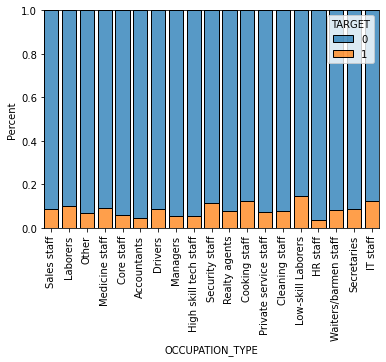

In [67]:
sns.histplot(x=sample["OCCUPATION_TYPE"].fillna('Other'), stat='percent', hue=sample["TARGET"], multiple="fill", shrink=.8)
plt.xticks(rotation=90)

plt.show()

In [68]:
pd.crosstab(sample['OCCUPATION_TYPE'].fillna('Other'), sample['TARGET'], normalize='index')

TARGET                        0         1
OCCUPATION_TYPE                          
Accountants            0.957071  0.042929
Cleaning staff         0.924731  0.075269
Cooking staff          0.875502  0.124498
Core staff             0.939633  0.060367
Drivers                0.912517  0.087483
HR staff               0.964286  0.035714
High skill tech staff  0.945415  0.054585
IT staff               0.875000  0.125000
Laborers               0.900045  0.099955
Low-skill Laborers     0.853933  0.146067
Managers               0.947681  0.052319
Medicine staff         0.907781  0.092219
Other                  0.932481  0.067519
Private service staff  0.925620  0.074380
Realty agents          0.921053  0.078947
Sales staff            0.915527  0.084473
Secretaries            0.912281  0.087719
Security staff         0.883895  0.116105
Waiters/barmen staff   0.918367  0.081633

In [69]:
imputed_columns.append('OCCUPATION_TYPE')
imputed_columns

['OWN_CAR_AGE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OCCUPATION_TYPE']

In [70]:
# fill missing values of train and test dataframes
train = imputed_flag_column(train, 'OCCUPATION_TYPE')
test = imputed_flag_column(test, 'OCCUPATION_TYPE')

train = train.fillna('Other',subset=['OCCUPATION_TYPE'])
test = test.fillna('Other',subset=['OCCUPATION_TYPE'])

The next collection of variables with missing values correspond to the number of enquiries to Credit Bureau about the client making the application.

In [71]:
credit_bureau_cols = columns_missing[columns_missing['column'].str.contains("AMT_REQ")]
credit_bureau_cols

column   dtype  fraction_of_missing
116  AMT_REQ_CREDIT_BUREAU_HOUR  double             0.132936
117   AMT_REQ_CREDIT_BUREAU_DAY  double             0.132936
118  AMT_REQ_CREDIT_BUREAU_WEEK  double             0.132936
119   AMT_REQ_CREDIT_BUREAU_MON  double             0.132936
120   AMT_REQ_CREDIT_BUREAU_QRT  double             0.132936
121  AMT_REQ_CREDIT_BUREAU_YEAR  double             0.132936

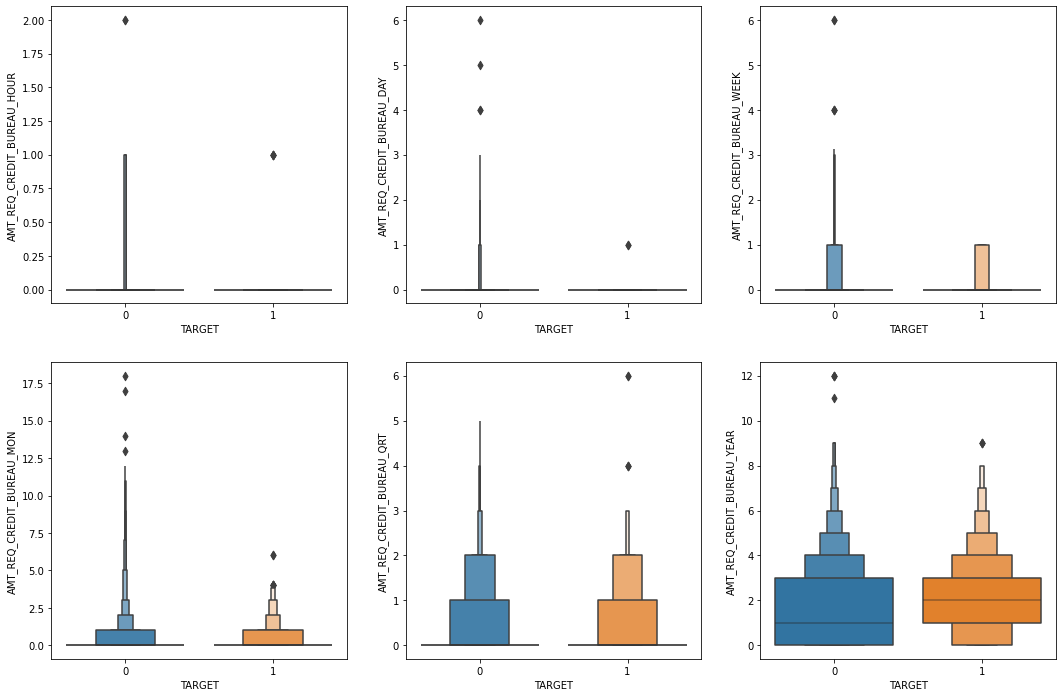

In [72]:
fig, ax = plt.subplots(2, 3, figsize=(18,12))
ax = ax.flatten()

for i, col in enumerate(credit_bureau_cols['column']):
    sns.boxenplot(data=sample, y=col, x='TARGET', ax=ax[i])
    #sns.histplot(data=sample, x=col, hue='TARGET', kde=True, ax=ax[i])

plt.show()

In [189]:
sample['AMT_REQ_CREDIT_BUREAU_YEAR'].median()

1.0

Apparently only AMT_REQ_CREDIT_BUREAU_YEAR contains relevant information about whether a client is likely to default or not. Let's drop the other columns and impute missing values with the global median. 

In [73]:
cols_to_drop = list(credit_bureau_cols['column'].values[:-1])

train = train.drop(*cols_to_drop)
test = test.drop(*cols_to_drop)

In [76]:
imputed_columns.append('AMT_REQ_CREDIT_BUREAU_YEAR')
imputed_columns

['OWN_CAR_AGE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OCCUPATION_TYPE',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [74]:
train = imputed_flag_column(train, 'AMT_REQ_CREDIT_BUREAU_YEAR')
test = imputed_flag_column(test, 'AMT_REQ_CREDIT_BUREAU_YEAR')

In [75]:
from pyspark.ml.feature import Imputer

imputer = Imputer(strategy = 'median',
    inputCols=['AMT_REQ_CREDIT_BUREAU_YEAR'], 
    outputCols=['AMT_REQ_CREDIT_BUREAU_YEAR']
)

model = imputer.fit(train)

In [77]:
# Transform column 
train = model.transform(train)
test = model.transform(test)

In [78]:
columns_missing.sort_values(by='fraction_of_missing', ascending=False).head(20)

column   dtype  fraction_of_missing
21                  OWN_CAR_AGE  double             0.654689
41                 EXT_SOURCE_1  double             0.561473
28              OCCUPATION_TYPE  string             0.315018
43                 EXT_SOURCE_3  double             0.200048
116  AMT_REQ_CREDIT_BUREAU_HOUR  double             0.132936
121  AMT_REQ_CREDIT_BUREAU_YEAR  double             0.132936
117   AMT_REQ_CREDIT_BUREAU_DAY  double             0.132936
119   AMT_REQ_CREDIT_BUREAU_MON  double             0.132936
118  AMT_REQ_CREDIT_BUREAU_WEEK  double             0.132936
120   AMT_REQ_CREDIT_BUREAU_QRT  double             0.132936
11              NAME_TYPE_SUITE  string             0.004109
92     DEF_30_CNT_SOCIAL_CIRCLE  double             0.002498
94     DEF_60_CNT_SOCIAL_CIRCLE  double             0.002498
93     OBS_60_CNT_SOCIAL_CIRCLE  double             0.002498
91     OBS_30_CNT_SOCIAL_CIRCLE  double             0.002498
42                 EXT_SOURCE_2  double             0.001853
10              AMT_GOODS_PRICE  double             0.001209
9                   AMT_ANNUITY  double             0.000081
101             FLAG_DOCUMENT_7     int             0.000000
95       DAYS_LAST_PHONE_CHANGE  double             0.000000

The NAME_TYPE_SUITE variable describes who was accompanying the client when he was applying for the loan. To fill missing values let's just create another category and create a flag column.

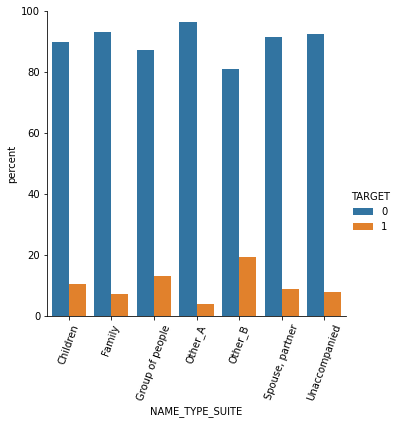

In [79]:
x,y = 'NAME_TYPE_SUITE', 'TARGET'

df1 = sample.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

plt.xticks(rotation=70)
plt.show()

In [80]:
imputed_columns.append('NAME_TYPE_SUITE')
imputed_columns

['OWN_CAR_AGE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OCCUPATION_TYPE',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'NAME_TYPE_SUITE']

In [81]:
train = imputed_flag_column(train, 'NAME_TYPE_SUITE')
test = imputed_flag_column(test, 'NAME_TYPE_SUITE')

train = train.fillna('Unknown', subset=['NAME_TYPE_SUITE'])
test = test.fillna('Unknown', subset=['NAME_TYPE_SUITE'])

Variables related to the social circle of the client seem little relevant but we can keep them for the moment.

In [82]:
dpd_columns = columns_missing[columns_missing['column'].str.contains("SOCIAL_CIRCLE")]
dpd_columns

column   dtype  fraction_of_missing
91  OBS_30_CNT_SOCIAL_CIRCLE  double             0.002498
92  DEF_30_CNT_SOCIAL_CIRCLE  double             0.002498
93  OBS_60_CNT_SOCIAL_CIRCLE  double             0.002498
94  DEF_60_CNT_SOCIAL_CIRCLE  double             0.002498

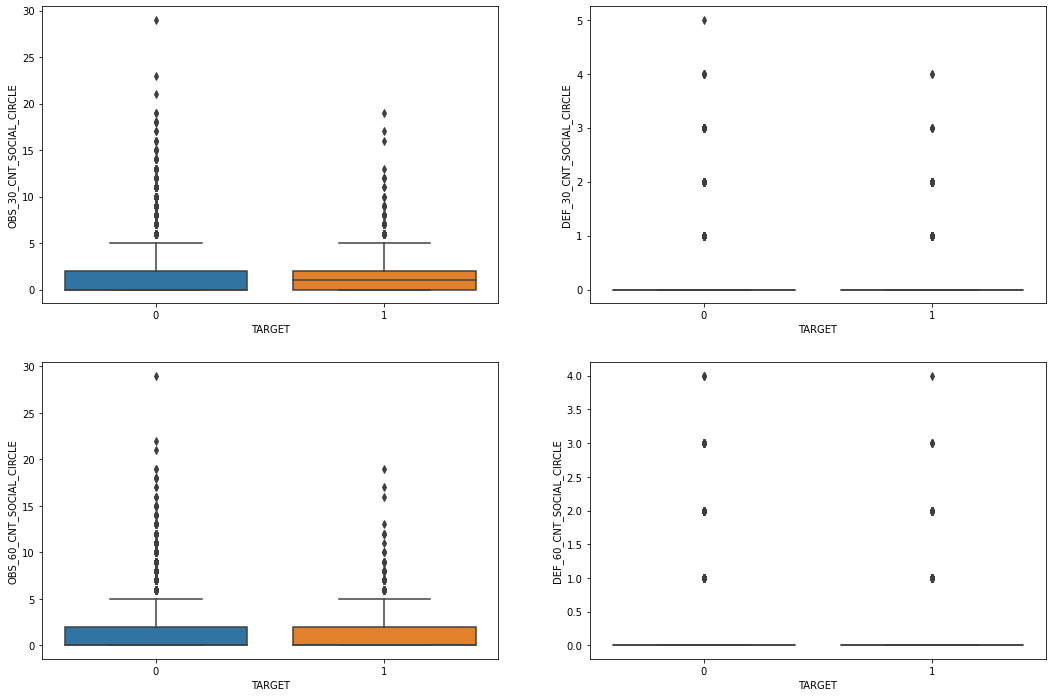

In [83]:
fig, ax = plt.subplots(2, 2, figsize=(18,12))
ax = ax.flatten()

for i, col in enumerate(dpd_columns['column']):
    sns.boxplot(data=sample, y=col, x='TARGET', ax=ax[i])
    #sns.histplot(data=sample, x=col, hue='TARGET', kde=True, ax=ax[i])

plt.show()

In [214]:
pd.crosstab(sample['OBS_30_CNT_SOCIAL_CIRCLE'], sample['TARGET'], margins=True, normalize='index')

TARGET                           0         1
OBS_30_CNT_SOCIAL_CIRCLE                    
0.0                       0.927345  0.072655
1.0                       0.923379  0.076621
2.0                       0.914931  0.085069
3.0                       0.930993  0.069007
4.0                       0.893728  0.106272
5.0                       0.914062  0.085938
6.0                       0.913978  0.086022
7.0                       0.915423  0.084577
8.0                       0.884615  0.115385
9.0                       0.893333  0.106667
10.0                      0.950000  0.050000
11.0                      0.941176  0.058824
12.0                      0.800000  0.200000
13.0                      0.941176  0.058824
14.0                      1.000000  0.000000
15.0                      1.000000  0.000000
16.0                      0.800000  0.200000
17.0                      0.666667  0.333333
18.0                      1.000000  0.000000
19.0                      0.666667  0.333333
21.0                      1.000000  0.000000
23.0                      1.000000  0.000000
29.0                      1.000000  0.000000
All                       0.922704  0.077296

In [84]:
imputed_columns.extend(list(dpd_columns['column'].values))
imputed_columns

['OWN_CAR_AGE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OCCUPATION_TYPE',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'NAME_TYPE_SUITE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE']

In [85]:
for col in list(dpd_columns['column'].values):
    train = imputed_flag_column(train, col)
    test = imputed_flag_column(test, col)

In [88]:
dpd_cols = list(dpd_columns['column'].values)
dpd_cols

['OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE']

In [89]:
imputer = Imputer(strategy = 'median',
    inputCols=dpd_cols, 
    outputCols=dpd_cols
)

model = imputer.fit(train)

In [90]:
train = model.transform(train)
test = model.transform(test)

In [94]:
columns.sort_values(by='fraction_of_missing', ascending=False)

column   dtype  fraction_of_missing
76                COMMONAREA_MEDI  double             0.698723
48                 COMMONAREA_AVG  double             0.698723
62                COMMONAREA_MODE  double             0.698723
70       NONLIVINGAPARTMENTS_MODE  double             0.694330
56        NONLIVINGAPARTMENTS_AVG  double             0.694330
84       NONLIVINGAPARTMENTS_MEDI  double             0.694330
86             FONDKAPREMONT_MODE  string             0.683862
68          LIVINGAPARTMENTS_MODE  double             0.683550
54           LIVINGAPARTMENTS_AVG  double             0.683550
82          LIVINGAPARTMENTS_MEDI  double             0.683550
52                  FLOORSMIN_AVG  double             0.678486
66                 FLOORSMIN_MODE  double             0.678486
80                 FLOORSMIN_MEDI  double             0.678486
75               YEARS_BUILD_MEDI  double             0.664978
61               YEARS_BUILD_MODE  double             0.664978
47                YEARS_BUILD_AVG  double             0.664978
21                    OWN_CAR_AGE  double             0.659908
81                  LANDAREA_MEDI  double             0.593767
67                  LANDAREA_MODE  double             0.593767
53                   LANDAREA_AVG  double             0.593767
73              BASEMENTAREA_MEDI  double             0.585160
45               BASEMENTAREA_AVG  double             0.585160
59              BASEMENTAREA_MODE  double             0.585160
41                   EXT_SOURCE_1  double             0.563811
71             NONLIVINGAREA_MODE  double             0.551792
57              NONLIVINGAREA_AVG  double             0.551792
85             NONLIVINGAREA_MEDI  double             0.551792
77                 ELEVATORS_MEDI  double             0.532960
49                  ELEVATORS_AVG  double             0.532960
63                 ELEVATORS_MODE  double             0.532960
89             WALLSMATERIAL_MODE  string             0.508408
72                APARTMENTS_MEDI  double             0.507497
44                 APARTMENTS_AVG  double             0.507497
58                APARTMENTS_MODE  double             0.507497
78                 ENTRANCES_MEDI  double             0.503488
50                  ENTRANCES_AVG  double             0.503488
64                 ENTRANCES_MODE  double             0.503488
55                 LIVINGAREA_AVG  double             0.501933
69                LIVINGAREA_MODE  double             0.501933
83                LIVINGAREA_MEDI  double             0.501933
87                 HOUSETYPE_MODE  string             0.501761
65                 FLOORSMAX_MODE  double             0.497608
79                 FLOORSMAX_MEDI  double             0.497608
51                  FLOORSMAX_AVG  double             0.497608
60   YEARS_BEGINEXPLUATATION_MODE  double             0.487810
74   YEARS_BEGINEXPLUATATION_MEDI  double             0.487810
46    YEARS_BEGINEXPLUATATION_AVG  double             0.487810
88                 TOTALAREA_MODE  double             0.482685
90            EMERGENCYSTATE_MODE  string             0.473983
28                OCCUPATION_TYPE  string             0.313455
43                   EXT_SOURCE_3  double             0.198253
116    AMT_REQ_CREDIT_BUREAU_HOUR  double             0.135016
117     AMT_REQ_CREDIT_BUREAU_DAY  double             0.135016
118    AMT_REQ_CREDIT_BUREAU_WEEK  double             0.135016
119     AMT_REQ_CREDIT_BUREAU_MON  double             0.135016
120     AMT_REQ_CREDIT_BUREAU_QRT  double             0.135016
121    AMT_REQ_CREDIT_BUREAU_YEAR  double             0.135016
11                NAME_TYPE_SUITE  string             0.004201
91       OBS_30_CNT_SOCIAL_CIRCLE  double             0.003320
92       DEF_30_CNT_SOCIAL_CIRCLE  double             0.003320
93       OBS_60_CNT_SOCIAL_CIRCLE  double             0.003320
94       DEF_60_CNT_SOCIAL_CIRCLE  double             0.003320
42                   EXT_SOURCE_2  double             0.00

There remains four variables with missing values: AMT_GOODS_PRICE, AMT_ANNUITY, CNT_FAM_MEMBERS and DAYS_LAST_PHONE_CHANGE. Since the fraction of missing values is very small I will simply drop these rows.

In [99]:
train = train.dropna(how='any', subset=['CODE_GENDER', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 
                                        'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE'])
test = test.dropna(how='any', subset=['CODE_GENDER', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 
                                        'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE'])

In [100]:
columns_train = columns_info(train)
columns_test = columns_info(test)

The next step in the data processing stage is encoding categorical variables 

In [105]:
# save train and test sets as parquet files
train.write.parquet("files/train.parquet")
test.write.parquet("files/test.parquet")

## Categorical Encoding

Before we can apply a machine learning model to our data we need to convert all categorical features into numerical features. There are many techniques to do this such as one-hot encoding, ordinal encoding, target encoding, etc. The method to use depends on the nature of the feature we are trying to convert. For example, for features with high cardinality one-hot encoding is not recommended since it can significantly increase the number of features. 

In [8]:
train = spark.read.parquet("files/train.parquet")
test = spark.read.parquet("files/test.parquet")

In [9]:
columns_train = columns_info(train)
columns_test = columns_info(test)

23/07/24 19:00:40 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [10]:
dataframe_info(train)

Columns datatypes counts
int :  56
string :  9
double :  18
Number of columns:  83
Number of rows:  245684




In [11]:
categorical_columns = columns_train[columns_train['dtype']=='string']
categorical_columns = list(categorical_columns['column'].values)
categorical_columns

['NAME_CONTRACT_TYPE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE']

From all categorical columns only two of them have a cardinality larger than 15: OCCUPATION_TYPE (19) and ORGANIZATION_TYPE (58). This means that applying one-hot to them will increase the number of features by 75. Since the dataset is not very large let's apply one-hot encoding to all variables.

In [35]:
train.select([F.countDistinct(c).alias(c) for c in categorical_columns]).show(vertical=True)

-RECORD 0-------------------------
 NAME_CONTRACT_TYPE         | 2   
 NAME_TYPE_SUITE            | 8   
 NAME_INCOME_TYPE           | 8   
 NAME_EDUCATION_TYPE        | 5   
 NAME_FAMILY_STATUS         | 5   
 NAME_HOUSING_TYPE          | 6   
 OCCUPATION_TYPE            | 19  
 WEEKDAY_APPR_PROCESS_START | 7   
 ORGANIZATION_TYPE          | 58  



In [13]:
test.select([F.countDistinct(c).alias(c) for c in categorical_columns]).show(vertical=True)

-RECORD 0-------------------------
 NAME_CONTRACT_TYPE         | 2   
 NAME_TYPE_SUITE            | 8   
 NAME_INCOME_TYPE           | 7   
 NAME_EDUCATION_TYPE        | 5   
 NAME_FAMILY_STATUS         | 5   
 NAME_HOUSING_TYPE          | 6   
 OCCUPATION_TYPE            | 19  
 WEEKDAY_APPR_PROCESS_START | 7   
 ORGANIZATION_TYPE          | 58  



In [14]:
for col in categorical_columns:
    train.groupBy(col).count().orderBy('count').show(60)
    test.groupBy(col).count().orderBy('count').show(60)

+------------------+------+
|NAME_CONTRACT_TYPE| count|
+------------------+------+
|   Revolving loans| 23099|
|        Cash loans|222585|
+------------------+------+

+------------------+-----+
|NAME_CONTRACT_TYPE|count|
+------------------+-----+
|   Revolving loans| 5898|
|        Cash loans|55634|
+------------------+-----+

+---------------+------+
|NAME_TYPE_SUITE| count|
+---------------+------+
|Group of people|   215|
|        Other_A|   699|
|        Unknown|   833|
|        Other_B|  1417|
|       Children|  2550|
|Spouse, partner|  9059|
|         Family| 32126|
|  Unaccompanied|198785|
+---------------+------+

+---------------+-----+
|NAME_TYPE_SUITE|count|
+---------------+-----+
|Group of people|   56|
|        Other_A|  167|
|        Unknown|  181|
|        Other_B|  353|
|       Children|  717|
|Spouse, partner| 2311|
|         Family| 8021|
|  Unaccompanied|49726|
+---------------+-----+

+--------------------+------+
|    NAME_INCOME_TYPE| count|
+-----------------

In [14]:
sample = train.sample(withReplacement=False, fraction=0.10, seed=42)

In [15]:
sample = sample.toPandas()

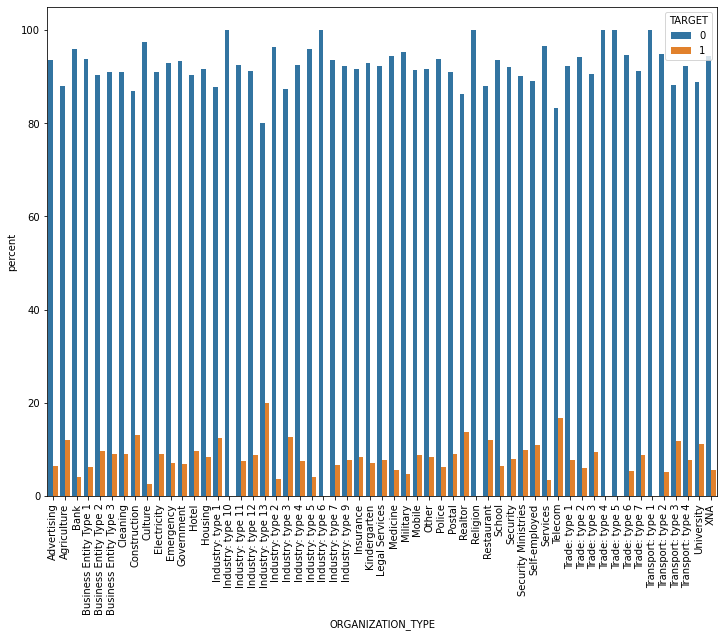

In [16]:
x,y = 'ORGANIZATION_TYPE', 'TARGET'

fig, ax = plt.subplots(1, 1, figsize=(12,9))

df1 = sample.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.barplot(x=x,y='percent',hue=y,data=df1, ax=ax)
#g.ax.set_ylim(0,100)

plt.xticks(rotation=90)
plt.show()

To apply one-hot encoding to categotical features we use a pipeline that also contains other takes care of other task needed to build machine learning models. Remember that some algorithms require data to be scaled to work properly. Let's also add this stage to our pipeline.

In [12]:
# Import classes for feature encoding and model building
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler, RobustScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [13]:
train.columns[0:10]

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY']

In [14]:
# This defines column names for StringIndexed features that result from StringIndexer
categorical_columns_idx = [col + '_idx' for col in categorical_columns]
categorical_columns_idx

['NAME_CONTRACT_TYPE_idx',
 'NAME_TYPE_SUITE_idx',
 'NAME_INCOME_TYPE_idx',
 'NAME_EDUCATION_TYPE_idx',
 'NAME_FAMILY_STATUS_idx',
 'NAME_HOUSING_TYPE_idx',
 'OCCUPATION_TYPE_idx',
 'WEEKDAY_APPR_PROCESS_START_idx',
 'ORGANIZATION_TYPE_idx']

In [15]:
# Defines names for one-hot encoded features
categorical_columns_dummy = [col + '_dummy' for col in categorical_columns]
categorical_columns_dummy

['NAME_CONTRACT_TYPE_dummy',
 'NAME_TYPE_SUITE_dummy',
 'NAME_INCOME_TYPE_dummy',
 'NAME_EDUCATION_TYPE_dummy',
 'NAME_FAMILY_STATUS_dummy',
 'NAME_HOUSING_TYPE_dummy',
 'OCCUPATION_TYPE_dummy',
 'WEEKDAY_APPR_PROCESS_START_dummy',
 'ORGANIZATION_TYPE_dummy']

Since the classes are unbalanced we need to account for this by weighting each class differently. To do this we follow the "balanced" mode used in sci-kit learn.

In [16]:
train.groupBy('TARGET').agg({'TARGET':'count'}).show()

+------+-------------+
|TARGET|count(TARGET)|
+------+-------------+
|     1|        19875|
|     0|       225809|
+------+-------------+



In [17]:
n_samples = train.count()

w0 = n_samples / (2*225809)
w1 = n_samples / (2*19875)
w0, w1

(0.5440084319048399, 6.1807295597484275)

In [18]:
train = train.withColumn('weight', F.when(train['TARGET']==0, w0).when(train['TARGET']==1, w1))
test = test.withColumn('weight', F.when(test['TARGET']==0, w0).when(test['TARGET']==1, w1))

In [19]:
feature_columns = train.columns
feature_columns.remove('TARGET')
feature_columns.remove('weight')
feature_columns.remove('SK_ID_CURR')

for col in categorical_columns:
    feature_columns.remove(col)
    
feature_columns.extend(categorical_columns_dummy)

In [20]:
feature_columns

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_

Now we create the transformers objects to be used in the pipeline

In [21]:
indexer = StringIndexer(inputCols=categorical_columns, outputCols=categorical_columns_idx, handleInvalid='keep')
encoder = OneHotEncoder(inputCols=categorical_columns_idx, outputCols=categorical_columns_dummy)
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features_unscaled')
scaler = RobustScaler(inputCol='features_unscaled', outputCol='features')

logistic= LogisticRegression(labelCol='TARGET', weightCol='weight')
random_forest = RandomForestClassifier(featuresCol='features_unscaled', labelCol='TARGET', numTrees=25, maxDepth=10, weightCol='weight', impurity='entropy')
gbt_cls = GBTClassifier(featuresCol='features_unscaled', labelCol='TARGET', weightCol='weight', maxDepth=8)

In [22]:
# Define a pipeline for each algorithm
pipeline_logistic = Pipeline(stages=[indexer, encoder, assembler, scaler, logistic])
pipeline_rf = Pipeline(stages=[indexer, encoder, assembler, random_forest])
pipeline_gbt = Pipeline(stages=[indexer, encoder, assembler, gbt_cls])

In [23]:
#pipeline_logistic = pipeline_logistic.fit(train)
pipeline_rf = pipeline_rf.fit(train)
#pipeline_gbt = pipeline_gbt.fit(train)

23/07/24 19:04:19 WARN DAGScheduler: Broadcasting large task binary with size 1198.9 KiB
23/07/24 19:04:27 WARN DAGScheduler: Broadcasting large task binary with size 1881.1 KiB
23/07/24 19:04:36 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


In [24]:
#predictions = pipeline_logistic.transform(test)
predictions = pipeline_rf.transform(test)

To evaluate the performance of the machine learning model we can compute different metrics that describe the generalization ability of the model using the test dataset. Depending on the context we might prefer one metric over the other. For example, if type I (false positives) errors are costly we can use **precision** to measure the performance of our model, if type II (false negatives) are more important then we can use **recall**.  

In [25]:
evaluatorAUROC = BinaryClassificationEvaluator(labelCol='TARGET', metricName='areaUnderROC')
evaluatorAccuracy = MulticlassClassificationEvaluator(labelCol='TARGET', metricName='accuracy', metricLabel=1.0)

evaluatorPrecision = MulticlassClassificationEvaluator(labelCol='TARGET', metricName='precisionByLabel', metricLabel=1.0)
evaluatorWeightedPrecision = MulticlassClassificationEvaluator(labelCol='TARGET', metricName='weightedPrecision', metricLabel=1.0)

evaluatorRecall = MulticlassClassificationEvaluator(labelCol='TARGET', metricName='recallByLabel', metricLabel=1.0)
evaluatorWeightedRecall = MulticlassClassificationEvaluator(labelCol='TARGET', metricName='weightedRecall', metricLabel=1.0)

evaluatorF1 = MulticlassClassificationEvaluator(labelCol='TARGET', metricName='f1', metricLabel=1.0)

In [26]:
roc = evaluatorAUROC.evaluate(predictions)
acc = evaluatorAccuracy.evaluate(predictions)
precision_weighted = evaluatorWeightedPrecision.evaluate(predictions)
precision = evaluatorPrecision.evaluate(predictions)
recall_weighted = evaluatorWeightedRecall.evaluate(predictions)
recall = evaluatorRecall.evaluate(predictions)
f1 = evaluatorF1.evaluate(predictions)

23/07/24 19:05:31 WARN DAGScheduler: Broadcasting large task binary with size 1998.8 KiB
23/07/24 19:05:42 WARN DAGScheduler: Broadcasting large task binary with size 2010.6 KiB
23/07/24 19:05:51 WARN DAGScheduler: Broadcasting large task binary with size 2010.6 KiB
23/07/24 19:05:57 WARN DAGScheduler: Broadcasting large task binary with size 2010.6 KiB
23/07/24 19:06:06 WARN DAGScheduler: Broadcasting large task binary with size 2010.6 KiB
23/07/24 19:06:13 WARN DAGScheduler: Broadcasting large task binary with size 2010.6 KiB
23/07/24 19:06:20 WARN DAGScheduler: Broadcasting large task binary with size 2010.6 KiB


In [27]:
roc, acc, precision, precision_weighted, recall, recall_weighted, f1

(0.7300391349076039,
 0.6930865240850289,
 0.15523715415019762,
 0.8925201117793087,
 0.6374518157841347,
 0.6930865240850289,
 0.7624375274440339)

In [27]:
group = predictions.groupBy(['TARGET', 'prediction']).count()

In [29]:
group.show()

23/07/24 18:35:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/07/24 18:35:26 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


+------+----------+-----+
|TARGET|prediction|count|
+------+----------+-----+
|     1|       0.0| 1792|
|     0|       0.0|39834|
|     1|       1.0| 3137|
|     0|       1.0|16769|
+------+----------+-----+



## Final notes

Using a single test set to estimate the generalization error is not recommended. Instead we can perform this estimation using k-fold cross validation that splits the train dataset into k parts and computes the error using each one of this parts as a test set. This can be done in pyspark using the **CrossValidator** class and creating a grid of hyperparameters to select the best model. However this task is computationally expensive and and requires using the full power of a cluster. I do not try to make this implementation since this is a local environment that uses a single computer to perform calculations.

## Other tests

In [ ]:
negative = train.filter(train['TARGET']==0).sample(fraction=ratio, seed=42)
positive = train.filter(train['TARGET']==1)

train_ = positive.unionAll(negative)

In [197]:
train_.count(), test.count()

(39560, 61532)

In [211]:
train_.groupBy('TARGET').agg({'TARGET':'count'}).show()

+------+-------------+
|TARGET|count(TARGET)|
+------+-------------+
|     1|        19875|
|     0|        19685|
+------+-------------+



In [198]:
train_ = train_.withColumn('weight', F.when(train_['TARGET']==0, w0).when(train_['TARGET']==1, w1))
test = test.withColumn('weight', F.when(test['TARGET']==0, w0).when(test['TARGET']==1, w1))

In [262]:
train_.columns

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_

In [110]:
w1 = 19875/245684 
w0 = 1 - w1
w0, w1

(0.9191034011168818, 0.08089659888311815)

In [282]:
group = predictions.groupBy(['TARGET', 'prediction']).count()

In [283]:
group.show()

23/07/19 23:08:25 WARN DAGScheduler: Broadcasting large task binary with size 31.9 MiB
23/07/19 23:08:57 WARN DAGScheduler: Broadcasting large task binary with size 31.8 MiB


+------+----------+-----+
|TARGET|prediction|count|
+------+----------+-----+
|     1|       0.0|  440|
|     0|       0.0|16349|
|     1|       1.0| 4489|
|     0|       1.0|40254|
+------+----------+-----+



In [86]:
56545 / (56545 + 58)

0.9989753193293641

In [88]:
51/(51+4878)

0.010346926354230066

In [150]:
y = np.array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

len(y)/(2*np.bincount(y))

array([0.71428571, 1.66666667])

In [151]:
np.bincount(y)

array([14,  6])